In [12]:
# Standard Libraries
import warnings
import itertools
from datetime import datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine Learning & Evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, classification_report

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier


# Setting styles and ignoring warnings
sns.set(style='white')
plt.style.use("ggplot")
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore')
%matplotlib inline


In [13]:
df=pd.read_csv('https://drive.google.com/uc?export=download&id=1d2ur0h9lUlIrL5pnEAgBwDLTYoHrdm81' )
df.head()



,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,33946835189,20220000130414,33946824861,Field Contact,-,7482,1979,M,White,...,02:39:36.0000000,VICE - PROSTITUTION,VICE - PROSTITUTION,ONVIEW,WEST PCT 3RD W - MARY - PLATOON 1,N,N,West,K,K1
1,-,-1,20170000005258,342036,Field Contact,NaN,6355,1970,F,White,...,06:17:00.0000000,-,-,-,EAST PCT 1ST W - E/G RELIEF (CHARLIE),N,N,-,-,-
2,26 - 35,7733349602,20190000263182,8628041748,Arrest,-,6262,1973,M,White,...,06:24:25.0000000,"SUSPICIOUS PERSON, VEHICLE, OR INCIDENT",--PROWLER - TRESPASS,911,SOUTHWEST PCT 1ST W - FRANK - PLATOON 2,Y,N,Southwest,F,F2
3,36 - 45,-1,20160000005118,217915,Field Contact,NaN,5803,1971,M,American Indian/Alaska Native,...,16:38:00.0000000,-,-,-,WEST PCT 2ND W - DAVID BEATS,N,N,North,U,U3
4,46 - 55,-1,20150000227032,60297,Offense Report,Lethal Cutting Instrument,6355,1970,F,White,...,08:55:00.0000000,DISTURBANCE,"--WEAPON,PERSON WITH - OTHER WEAPON",911,EAST PCT 1ST W - E/G RELIEF (CHARLIE),N,Y,East,E,E1


In [14]:
# Check for null values:
print('row----- Column---- :',df.shape,'\n')
print(df.isna().sum())

row----- Column---- : (60102, 23) 

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 557
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64


In [15]:
# column to binary 0 or 1 Arrested or not arrested
df['Stop Resolution'] = df['Stop Resolution'].map({'Arrest': 1, 'Field Contact': 0,'Offense Report': 0,
                                                   'Referred for Prosecution': 0,'Citation / Infraction': 0})
df['Stop Resolution'].value_counts()

Stop Resolution
0    45473
1    14629
Name: count, dtype: int64

In [16]:
# Convert the 'Reported Date' column to datetime format
df['Reported Date'] = pd.to_datetime(df['Reported Date'])

# Create a dictionary for mapping month numbers to month names
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Add a new column for the month name
df['Month'] = df['Reported Date'].dt.month.map(month_mapping)

# Add new columns for the day and year
df['Day'] = df['Reported Date'].dt.day
df['Year'] = df['Reported Date'].dt.year


In [17]:
# Create a dictionary to map weapon types to categories
weapon_mapping = {
    'Lethal Cutting Instrument': 'Non-Firearm', 
    'Knife/Cutting/Stabbing Instrument': 'Non-Firearm',
    'Club, Blackjack, Brass Knuckles': 'Non-Firearm',
    'Blunt Object/Striking Implement': 'Non-Firearm',
    'Mace/Pepper Spray': 'Non-Firearm', 
    'Club': 'Non-Firearm',
    'Taser/Stun Gun': 'Non-Firearm', 
    'Blackjack': 'Non-Firearm',
    'Brass Knuckles': 'Non-Firearm', 
    'Fire/Incendiary Device': 'Non-Firearm',
    'Handgun': 'Firearm',
    'Firearm Other': 'Firearm',
    'Firearm (unk type)': 'Firearm',
    'Firearm': 'Firearm',
    
    'Other Firearm': 'Firearm', 
    'Rifle': 'Firearm',
    'Shotgun': 'Firearm',
    'Automatic Handgun': 'Firearm',
    'None': 'None',
    '-': 'None',
    'None/Not Applicable': 'None'
}

# Map the weapon types to the categories
df['Weapon Type'] = df['Weapon Type'].map(weapon_mapping)


In [18]:
# Change Officer year of birth to give the officer age:
df['Officer Age'] = 2020-df['Officer YOB']

In [19]:
# Drop columns that we are not going to need:
df.drop(columns=['Subject ID','GO / SC Num','Officer ID','Officer YOB','Officer Race',
                'Subject Perceived Gender','Subject Perceived Race','Reported Date','Reported Time','Call Type',
                'Officer Squad', 'Sector','Beat','Initial Call Type','Final Call Type','Day'],axis=1, inplace=True)
# See what our final dataset looks like
df.head()

df 

,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer Gender,Arrest Flag,Frisk Flag,Precinct,Month,Year,Officer Age
0,26 - 35,33946824861,0,None,M,N,N,West,May,2022,41
1,-,342036,0,NaN,F,N,N,-,November,2017,50
2,26 - 35,8628041748,1,None,M,Y,N,Southwest,July,2019,47
3,36 - 45,217915,0,NaN,M,N,N,North,December,2016,49
4,46 - 55,60297,0,Non-Firearm,F,N,Y,East,July,2015,50
...,...,...,...,...,...,...,...,...,...,...,...
60097,46 - 55,8252118453,0,None,F,N,Y,South,May,2019,29
60098,36 - 45,13172913355,1,None,M,Y,N,West,May,2020,33
60099,26 - 35,30544207813,1,None,M,Y,N,-,December,2021,28
60100,26 - 35,546819,1,NaN,F,N,N,East,March,2019,28


## Splitting the Data into Train and Test Sets

First, we select the features and the target variable from the dataframe `df`.

### Features:
- `Subject Age Group`
- `Weapon Type`
- `Arrest Flag`
- `Frisk Flag`
- `Precinct`
- `Month`
- `Year`
- `Officer Age`
- `Officer Gender`

### Target:
- `Stop Resolution`

In [20]:
# Split into train and test sets:
X = df.loc[:, ['Subject Age Group', 'Weapon Type', 'Arrest Flag', 'Frisk Flag','Precinct','Month',
               'Year','Officer Age', 'Officer Gender']]
y = df.loc[:, 'Stop Resolution']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## One-Hot Encoding Categorical Features

We will use `OneHotEncoder` from `sklearn.preprocessing` to convert categorical features into a format that can be provided to machine learning algorithms to do a better job in prediction.

### Steps:

1. **Instantiate and fit the `OneHotEncoder`:**
   ```python
   from sklearn.preprocessing import OneHotEncoder
   import pandas as pd

   # Instantiate the OneHotEncoder
   ohe = OneHotEncoder()

   # Fit the encoder on the training data
   ohe.fit(X_train)

In [33]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Instantiate and fit the OneHotEncoder
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

# Create a dataframe with both training and testing data to be used later:
ohe_df1 = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(X_train.columns))
ohe_df2 = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(X_test.columns))
ohe_df = pd.concat([ohe_df1, ohe_df2], ignore_index=True)


## Confusion Matrix Plot Function

The following function, `confusion_matrix_plot`, visualizes a confusion matrix for a classification model. It includes options for normalization, title, and color mapping.


In [34]:
# Define Confusion Matrix:
def confusion_matrix_plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add title and labels:
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add axis scales and tick marks:
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add labels to each cell:
    thresh = cm.max() / 2.
    # Iterate through confusion matrix and append labels to the plot:
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    # Add legend:
    plt.colorbar()
    plt.show()
    
# Use Arrested and Not Arrested for 0 and 1 classes 
class_names = ['Arrested','Not Arrested']

In [35]:
# Determine optimal parameters:
# Declare a baseline classifier:
dtree = DecisionTreeClassifier()

# Create a parameter grid and grid search to identify the best parameters:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(1,10),
    "min_samples_split": range(2,10)
}
gs_tree = GridSearchCV(dtree, param_grid, cv=5, n_jobs=-1)

# Fit the tuned parameters:
gs_tree.fit(X_train_ohe, y_train)

# Print best estimator parameters:
print(gs_tree.best_params_)

KeyboardInterrupt: 

# Decision Tree Classifier:

The following steps outline the process of creating a Decision Tree classifier, fitting it to the training data, making predictions on the test set, and evaluating the model's performance.


Decision Tree Accuracy:  86.91143031445844 %
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     13753
           1       1.00      0.45      0.62      4278

    accuracy                           0.87     18031
   macro avg       0.93      0.72      0.77     18031
weighted avg       0.89      0.87      0.85     18031



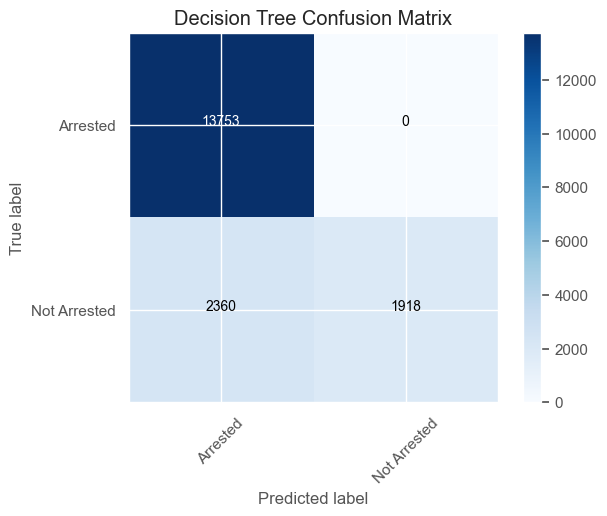

In [36]:
# Create the classifier, fit it on the training data and make predictions on the test set:
d_tree = DecisionTreeClassifier(criterion='gini',max_depth=1,min_samples_split=2)
d_tree = d_tree.fit(X_train_ohe, y_train)
y_pred = d_tree.predict(X_test_ohe)

# Check the Accuracy:
print('Decision Tree Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred))

# Confusion Matrix for Decision Tree
cm_dtree = confusion_matrix(y_test,y_pred)
confusion_matrix_plot(cm_dtree, classes=class_names, title='Decision Tree Confusion Matrix')

In [37]:
# Find optimial k value:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    '''This function will determine which k value is optimal to use for knn classification by selecting the k value
    with the highest overall accuracy score.
    Inputs:
    X_train, y_train, X_test, y_test: tran and test set values
    min_k: minimum value to try for k
    max_k: maximum value to try for k
        '''
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1,2):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        if accuracy > best_score:
            best_k = k
            best_score = accuracy
    
    print("Best Value for k: {}".format(best_k))
    print("Accuracy Score: {}".format(best_score))
    
print(find_best_k(X_train_ohe, y_train, X_test_ohe, y_test))

KeyboardInterrupt: 

# K-Nearest Neighbors (KNN) Classifier:

The following steps outline the process of creating a K-Nearest Neighbors classifier, fitting it to the training data, making predictions on the test set, and evaluating the model's performance.


KNN Accuracy:  86.71177416671289 %
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     13753
           1       0.89      0.50      0.64      4278

    accuracy                           0.87     18031
   macro avg       0.88      0.74      0.78     18031
weighted avg       0.87      0.87      0.85     18031



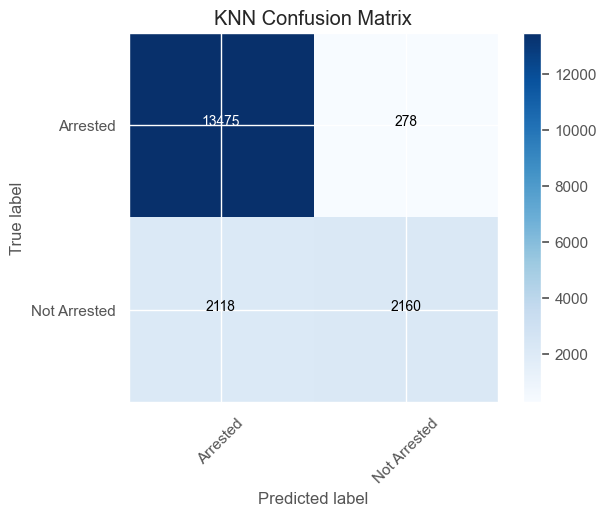

In [44]:
# Create the classifier, fit it on the training data and make predictions on the test set:
knn = KNeighborsClassifier(n_neighbors = 25, algorithm='brute')
knn.fit(X_train_ohe, y_train)
y_pred = knn.predict(X_test_ohe)

# Check the Accuracy:
print('KNN Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# Check the AUC:

# Print classification report:
print(classification_report(y_test, y_pred))

# Confusion Matrix for KNN:
cm_knn = confusion_matrix(y_test,y_pred)
confusion_matrix_plot(cm_knn, classes=class_names, title='KNN Confusion Matrix')

# Logistic Regression Classifier:

The following steps outline the process of creating a Logistic Regression classifier, fitting it to the training data, making predictions on the test set, and evaluating the model's performance.


Logistic Regression Accuracy:  86.58421607231989 %
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     13753
           1       0.90      0.49      0.63      4278

    accuracy                           0.87     18031
   macro avg       0.88      0.73      0.78     18031
weighted avg       0.87      0.87      0.85     18031



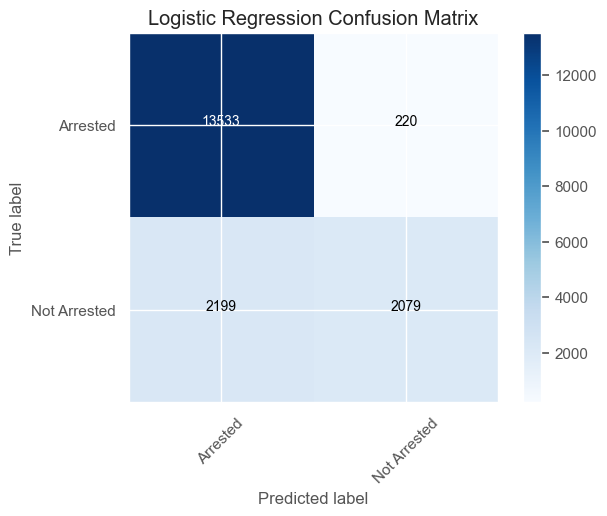

In [39]:
# Create the classifier, fit it on the training data and make predictions on the test set:
logreg = LogisticRegression()
logreg.fit(X_train_ohe, y_train)
y_pred = logreg.predict(X_test_ohe)

# Check the Accuracy:
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred))

# Confusion Matrix for Logistic Regression:
cm_LR = confusion_matrix(y_test,y_pred)
confusion_matrix_plot(cm_LR, classes=class_names, title='Logistic Regression Confusion Matrix')

In [50]:
# Determine optimal parameters:
# Declare a baseline classifier:
forest = RandomForestClassifier()

# Create a parameter grid and grid search:           
param_grid = {'n_estimators': [80, 100, 120],
              'criterion': ['gini', 'entropy'],
              'max_depth' : [None],
              'max_features': range(1,11), 
              'min_samples_split': range(1,6)}
forest_grid_search = GridSearchCV(forest, param_grid, cv=5, n_jobs=-1)

# Fit the tuned parameters:
forest_grid_search.fit(X_train_ohe, y_train)

# Printing best estimator parameters:
print(forest_grid_search.best_params_)

## Random Forest Classifier: Training, Prediction, and Evaluation

We will create a Random Forest classifier, fit it on the training data, make predictions on the test set, and then evaluate its performance using accuracy, classification report, and confusion matrix.


Random Forest Accuracy:  87.18318451555655 %
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     13753
           1       0.83      0.58      0.68      4278

    accuracy                           0.87     18031
   macro avg       0.86      0.77      0.80     18031
weighted avg       0.87      0.87      0.86     18031



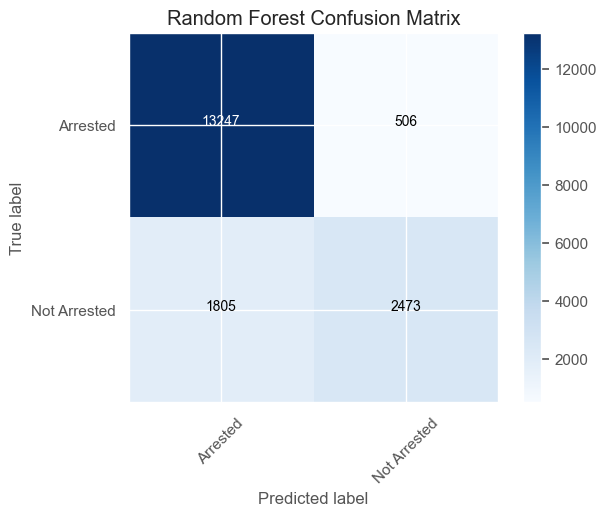

In [41]:
# Create the classifier, fit it on the training data and make predictions on the test set:
rforest = RandomForestClassifier(n_estimators=80, criterion = 'gini',max_depth=None, max_features=5, 
                                 min_samples_split=5)
rforest.fit(X_train_ohe, y_train)
y_pred = rforest.predict(X_test_ohe)

# Check the Accuracy:
print('Random Forest Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred))

# Confusion Matrix for Random Forest:
cm_forest = confusion_matrix(y_test,y_pred)
confusion_matrix_plot(cm_forest, classes=class_names, title='Random Forest Confusion Matrix')

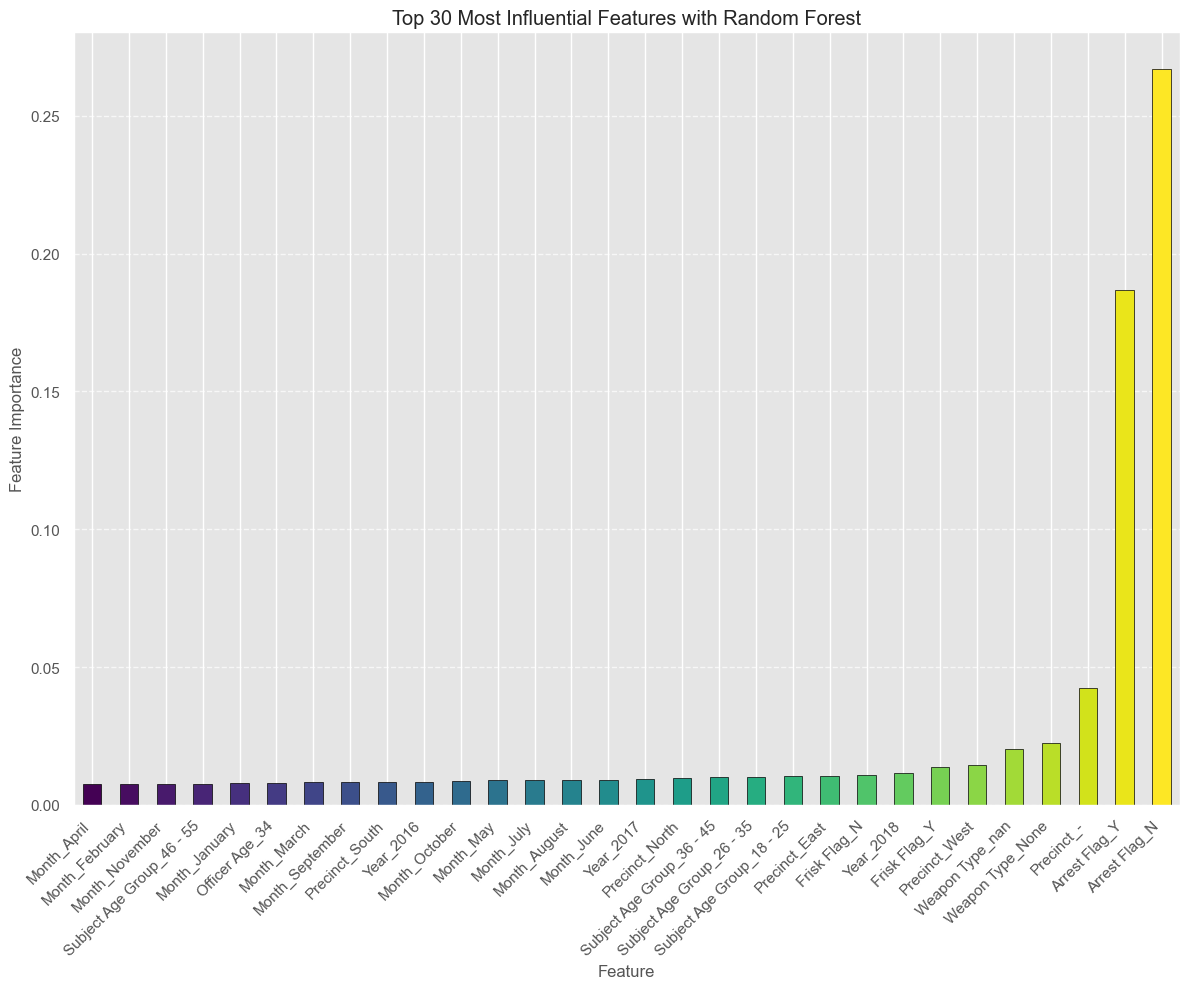

In [49]:
import numpy as np

# Calculate feature importances
feature_importances = pd.Series(rforest.feature_importances_, index=ohe_df.columns)

# Select the top 30 most influential features
top_features = feature_importances.nlargest(30)

# Create a vertical bar plot with custom styling
plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))  # Gradient color scheme
top_features.sort_values().plot(kind='bar', color=colors, edgecolor='black')
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.title('Top 30 Most Influential Features with Random Forest')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Terry Stops Analysis

## Conclusion

After evaluating the performance of four classification models on predicting the outcome of Terry Stops, the Random Forests model emerged as the most accurate, achieving an accuracy of 87.35%. The Decision Tree model followed closely behind with an accuracy of 79.96%, followed by Logistic Regression at 86.92%, and KNN at 86.72%.

Using the Random Forest model, we can predict with 87.19% accuracy whether a Terry Stop will result in an arrest. The most influential factors in this model include the precinct and the presence of an arrest flag. The top five features are:

1. Arrest Flag given
2. Arrest Flag not given
3. Unknown precinct
4. West Precinct
5. Frisk Flag given

### Recommendations:

1. **Training Officers:** Provide training to officers on discerning when it is appropriate to make an arrest during a Terry Stop versus when it might be better to wait, as this is a key indicator of arrests.

2. **Precinct Information:** Ensure the precinct information is accurately recorded for all Terry Stops to better predict the likelihood of an arrest.

3. **Frisk Procedures:** Train officers on the appropriate circumstances for conducting a "frisk," as this is another significant indicator of arrests.

### Next Steps:

While achieving 80% accuracy is promising, there is still room for improvement. Future efforts should focus on further tuning the model, potentially through additional data cleaning or adjusting the model inputs. Additionally, exploring other classification models, particularly deep learning models, could lead to a more accurate prediction model.
